In [491]:
%matplotlib inline
import pandas as pd
import numpy as np
import snow.utils as sf
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [492]:
raw_financials = sf.from_snow(role='all_data_viewer',wh='load_wh',db='all_data',q_kind='financials',to_df=False)
raw_financials = raw_financials[2:]

Using all_data_viewer...
Established connection.
Querying load_wh.all_data.postgres
Financials data:  (None, 0.0, 0.0, 0.0, 0.0, 0) 

Connection succesfully closed.


In [493]:
financials_df = pd.DataFrame(raw_financials
            ,columns=['ds','Gross revenue','Org. volume','Total volume','Org. count','Total count'])

In [494]:
financials_df.head()

,ds,Gross revenue,Org. volume,Total volume,Org. count,Total count
0,2019-05-25,7153.2270,47052.173,52062.81,1922.0,2559
1,2019-05-24,7374.5660,48448.496,53253.39,2372.0,2993
2,2019-05-23,5556.7795,35555.277,39608.01,1848.0,2424
3,2019-05-22,4430.1160,28505.358,31826.00,1768.0,2219
4,2019-05-21,4411.7930,29304.015,32610.72,1747.0,2167


In [495]:
total_volume_df = financials_df
total_volume_df = total_volume_df.drop(['Total volume','Gross revenue','Org. count','Total count'],axis=1)

In [496]:
total_volume_df.rename(index=str, columns={"Org. volume":"y"},inplace=True)
total_volume_df.sort_values(by='ds',ascending=False)

## Below line reverses the ordering of the dataframe
total_volume_df = total_volume_df.iloc[::-1]

In [498]:
# 13.5 MAPE model
model = Prophet(seasonality_mode='multiplicative'
            ,growth='linear'
            ,daily_seasonality=False
            ,weekly_seasonality=False
            ,yearly_seasonality=False
            ,mcmc_samples=100
            ,interval_width=0.9
           ).add_seasonality(name='weekly',period=7,fourier_order=20,prior_scale=30)
model.fit(total_volume_df.tail(548))

In [499]:
future = model.make_future_dataframe(periods=91)
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-11-24,300.267838,-717.623734,5317.173419,154.195409,440.875124,6.193777,4.769906,7.655651,6.193777,4.769906,7.655651,0.0,0.0,0.0,2160.059735
1,2017-11-25,298.998400,-931.035054,4673.501599,160.879220,438.536265,5.553846,4.220642,6.898646,5.553846,4.220642,6.898646,0.0,0.0,0.0,1959.589468
2,2017-11-26,297.728962,-1054.750828,4723.485768,167.563030,434.124462,4.949040,3.730244,6.226289,4.949040,3.730244,6.226289,0.0,0.0,0.0,1771.201452
3,2017-11-27,296.459525,-1511.636715,4359.432842,174.366402,431.872536,3.645249,2.666032,4.631213,3.645249,2.666032,4.631213,0.0,0.0,0.0,1377.128164
4,2017-11-28,295.190087,-1171.906473,4196.489694,181.222065,420.937079,3.935548,2.918850,4.985896,3.935548,2.918850,4.985896,0.0,0.0,0.0,1456.924914


In [500]:
df = forecast[['ds','yhat','yhat_lower','yhat_upper','trend','trend_upper','trend_lower']]

In [501]:
df.tail()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_upper,trend_lower
634,2019-08-20,49373.949512,39883.544431,57122.908674,10003.741651,12766.276359,7523.398948
635,2019-08-21,52264.639008,42127.037616,60283.029554,10041.245866,12832.825086,7531.974068
636,2019-08-22,58756.214856,47661.290385,68035.888591,10078.750081,12884.286605,7558.040433
637,2019-08-23,72774.073083,58972.134623,84264.653078,10116.254296,12957.786696,7581.427607
638,2019-08-24,66546.169580,53438.993904,77384.425969,10153.758511,13031.057759,7600.432595


In [502]:
from datetime import datetime

date = str(datetime.now().date())

sf.to_snow(df=df,schema='forecasts',table='organic_volume')

2019-05-26
Accepted dataframe object
Schema: forecasts already exists; updating organic_volume table.
organic_volume successfully updated.
Engine successfully closed


In [503]:
from datetime import datetime
import os

date = str(datetime.now().date())
print(date)

df = forecast[['ds','yhat_upper','yhat','yhat_lower']].sort_values(by='ds',ascending=False)
df.yhat = df.yhat.apply(lambda x:'$'+str(round(x,2)))
df.yhat_upper = df.yhat_upper.apply(lambda x:'$'+str(round(x,2)))
df.yhat_lower = df.yhat_lower.apply(lambda x:'$'+str(round(x,2)))
df = df.rename(columns={'yhat':'forecast','yhat_upper':'upper bound','yhat_lower':'lower bound'})
df.to_csv(os.getcwd()+'/forecasts/Organic_volume_{}.csv'.format(date),index=False)
df.head()

2019-05-26


,ds,upper bound,forecast,lower bound
638,2019-08-24,$77384.43,$66546.17,$53438.99
637,2019-08-23,$84264.65,$72774.07,$58972.13
636,2019-08-22,$68035.89,$58756.21,$47661.29
635,2019-08-21,$60283.03,$52264.64,$42127.04
634,2019-08-20,$57122.91,$49373.95,$39883.54


<Figure size 1440x2160 with 0 Axes>

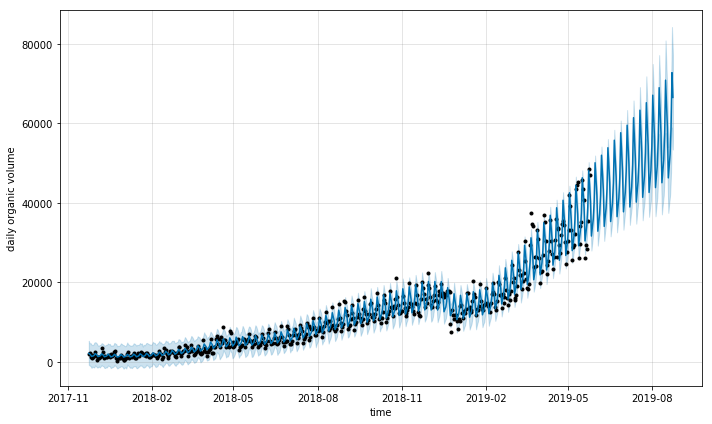

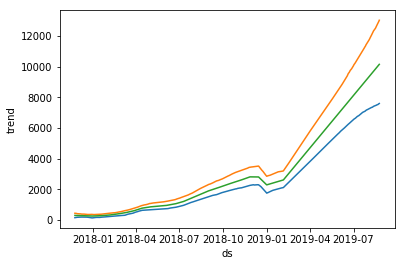

In [504]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,30))
fig1 = model.plot(forecast,ylabel='daily organic volume',xlabel='time')
plt.show()
sns.lineplot(data=forecast,x='ds',y='trend_lower')
sns.lineplot(data=forecast,x='ds',y='trend_upper')
sns.lineplot(data=forecast,x='ds',y='trend')

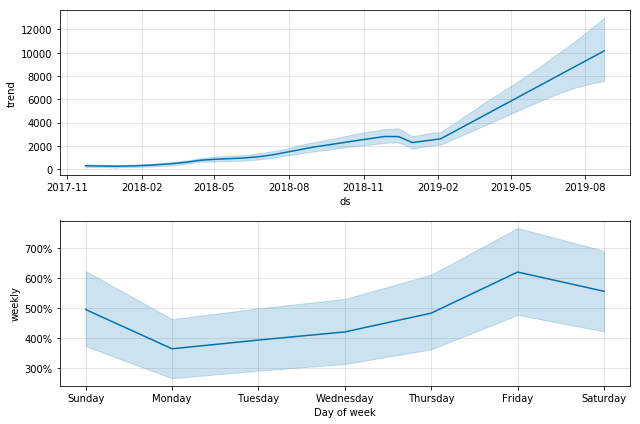

In [505]:
fig = model.plot_components(forecast)

In [507]:
import matplotlib.pyplot as plt
import seaborn as sns

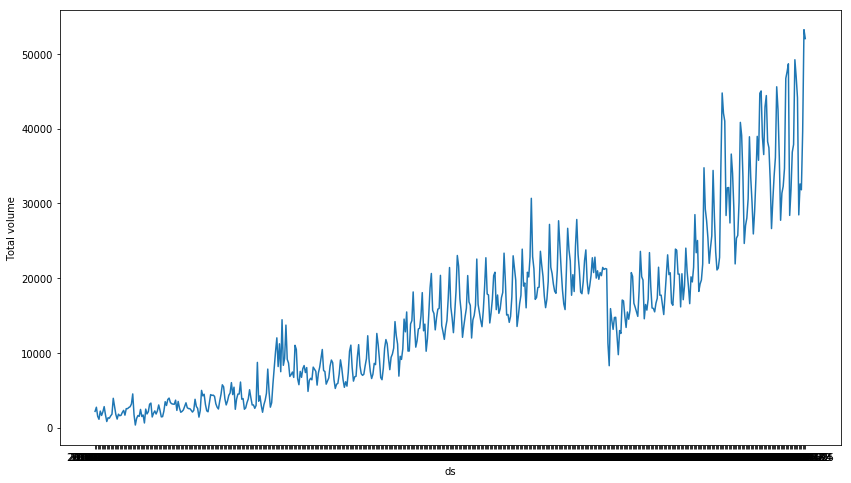

In [508]:
plt.figure(figsize=(14,8))
sns.lineplot(data=financials_df.head(548),x='ds',y='Total volume')
plt.show()

https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

Take in dataset, apply log transformation and forecast on that. Coax the data to make it more stationary like. Apply log transformation, predict the log, and then the transform the prediciton.



Another transformation is differencing. Take value of the difference between the 1st and 2nd points, then the 2nd and 3rd, and so on...


Explore whether the variants of the dataset are heteroskedastic -- i.e. is there a trend where variance , not just the y value, is growing or not.

Many models assume constant variance, so we need to adjust for multiplicate seasonal changes (i.e. multipled by a scalar value as opposed to just adding a constant bias factor) if the seasonal variance itself is growing. 

#### Augmented Dickey-Fuller test: what is the stationarity of the data set?

In [509]:
import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import adfuller

In [510]:
adfuller(x=financials_df['Org. volume'].values)

(-6.964097140516523,
 9.007558923273828e-10,
 25,
 1750,
 {'1%': -3.4340922388213175,
  '5%': -2.863192990001633,
  '10%': -2.5676500029387754},
 28770.55060871203)

###### Holy shit! Our dataset is actually highly stationary

### How can we measure the performance of our model?

In [511]:
def MAPE(y_true, y_pred):
    'Ingest true and predicted values, output Mean abolute percentage error score.'
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [512]:
cv_results = cross_validation(model, initial='112 days', period='56 days', horizon='28 days')
mape_baseline = MAPE(cv_results.y, cv_results.yhat)
mape_baseline

13.937423137193614

In [513]:
def plot_cross_validation_metric(
    df_cv, metric, rolling_window=0.1, ax=None, figsize=(10, 6)
):
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    # Get the metric at the level of individual predictions, and with the rolling window.
    df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
    df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

    # Some work because matplotlib does not handle timedelta
    # Target ~10 ticks.
    tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
    # Find the largest time resolution that has <1 unit per bin.
    dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
    dt_names = [
        'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
        'nanoseconds'
    ]
    dt_conversions = [
        24 * 60 * 60 * 10 ** 9,
        60 * 60 * 10 ** 9,
        60 * 10 ** 9,
        10 ** 9,
        10 ** 6,
        10 ** 3,
        1.,
    ]
    for i, dt in enumerate(dts):
        if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
            break

    x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
    x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])

    ax.plot(x_plt, df_none[metric], '.', alpha=0.5, c='gray')
    ax.plot(x_plt_h, df_h[metric], '-', c='b')
    ax.grid(True)

    ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
    ax.set_ylabel(metric)
    return fig

### mape aggressively penalises over-prediction; hence the model is biased towards conservative estimates

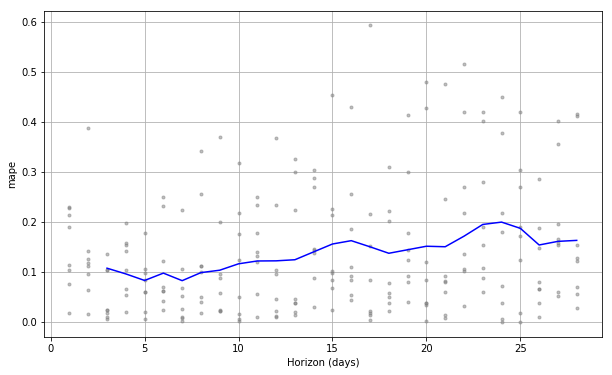

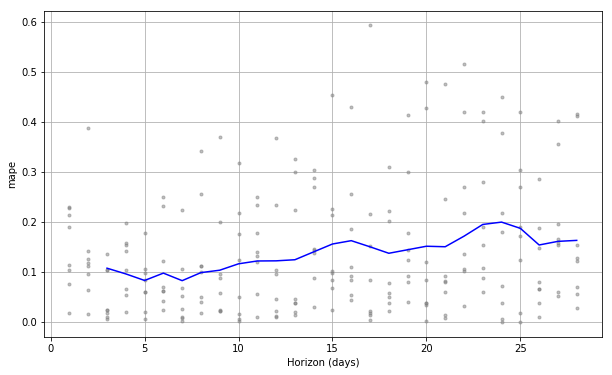

In [517]:
plot_cross_validation_metric(cv_results,'mape')

### Can we use one time series to predict the values of another?

##### Let's try using multivariate autoregressive models

https://en.wikipedia.org/wiki/Vector_autoregression

#### How do we test for one values predictive power over another?

https://en.wikipedia.org/wiki/Granger_causality
    
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html
    
Here, the first column is the dependent variable you want to predict and the second column is the variable you think can help predict the first variable. 

If p-value less than 0.05 (so significant), then the feature you are looking at DOES help to predict the variable

#### How many steps in advance is the 'cause' time-series most predictive of the 'effect' time-series?

How do we select for the ideal time-step? And by extension, optimize/select for the best model? The AIC test.

https://en.wikipedia.org/wiki/Akaike_information_criterion

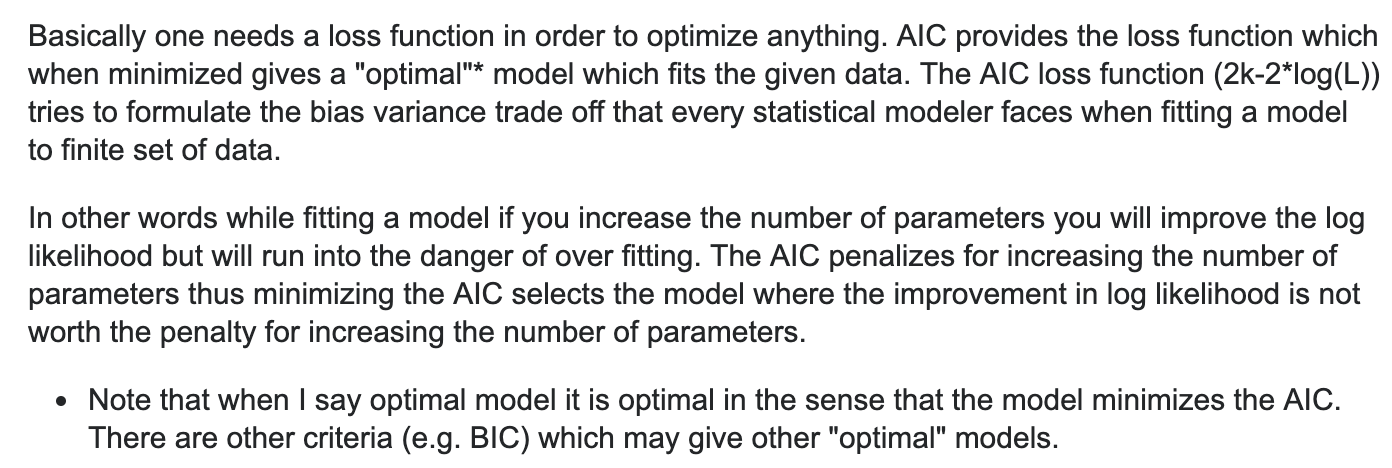

In [65]:
from IPython.display import Image
Image("AIC intuition.png")